## Step 1
Imports and initialisation of a LJ calculator

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import ase
from ase.visualize import view
from ase.optimize import BFGS
from ase.calculators.lj import LennardJones

lj_calc = LennardJones(sigma=1.0, epsilon=1.0, rc=12.0)

## Step 2
Initialisation of the simulation box. Parameters:
- 19 LJ atoms, I've chosen He
- Simulation box, side length is 12 - will adjust and justify with research
- Initialisation of positions, random within the box - will adjust and justify with research

### Simulation Box Length
Chosen 12 as suggested in assignment details

### Initial positions
When randomised across the entire box space, particles are so spaced out that instead of forming one 19-atom cluster, they form mini-clusters (typically 2 - 6 atoms, e.g. see trig-bipyramidal and tetrahedral structures attached). 

The reason for this is that the atoms are so far apart that they are not included in the calculation due to the cut-off (set at 4 Å). Even if the cut-off is increased to the size of the simulation box, the force between particles is so low that they will rarely converge.

So instead of randomising the particles across the entire simulation box, restrict the random space to a theoretical box in the centre of the simulation box that is half the size of entire simulation box.

In [2]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

def initialise_structure(n, box_length):
    
    cell = np.eye(3)*box_length # 3x3 matrix with 
    atoms = ase.Atoms(pbc=True, cell = cell)
    for i in range(n):
        #pos = np.random.rand(3)*cell[1,1] ## randomising positions across the entire simulation box -- doesn't yield desired structure as discussed in the above markdown cell
        pos = np.random.uniform(box_length*0.25, box_length*0.75, size = 3) # generates cartesian coordinates in the center of the simulation box 
        atoms.append(ase.Atom('He', position = pos))

    return atoms

lj_19 = initialise_structure(19, 12)

In [3]:
view(lj_19, viewer='x3d')

## Step 3

Test minimisation to determine parameters `fmax` and `steps` for an appropriate level of convergence.

Through various trials, the energy value (given to 6 decimal places here) doesn't fluctuate much (or at all) below `fmax = 0.001`, thus this seems a reasonable cutoff for a minima such that computation isn't "wasted"

However, I will come back to this, because instpecting fmax across the steps reveals that after 1024 the given trajectory isn't necessarily the lowest energy explored. There should be a way extract the position of the atoms at the lowest energy explored across the 1024 steps if it doesn't converge below `fmax = 0.001`

In [4]:
def minimise_structure(atoms, f_max=0.001, steps = 1024, id = "test"):
    atoms.calc = lj_calc
    dyn = BFGS(atoms=atoms, trajectory=f'./trajectories/{atoms.symbols}_{id}.traj') # set up BFGS minimiser for the desired Atoms object
    dyn.run(fmax=f_max,steps=steps) # perform minimisation

minimise_structure(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 18:11:55    83927.080230  2317387.311284
BFGS:    1 18:11:55       20.819863      408.620026
BFGS:    2 18:11:55       21.296116      408.505817
BFGS:    3 18:11:55       15.999862      406.763783
BFGS:    4 18:11:55        2.281777      174.989800
BFGS:    5 18:11:55        0.859685      156.542430
BFGS:    6 18:11:55       -4.049019       75.417454
BFGS:    7 18:11:55       -7.527186        3.795252
BFGS:    8 18:11:55       -7.863515        3.581249
BFGS:    9 18:11:55      -10.381000        7.001402
BFGS:   10 18:11:55       -0.510116      135.938269
BFGS:   11 18:11:55      -11.251701       12.532279
BFGS:   12 18:11:55      -11.096810       14.141884
BFGS:   13 18:11:55      -11.586562       13.336565
BFGS:   14 18:11:55      -12.868457        9.040070
BFGS:   15 18:11:55      -13.486892       10.039223
BFGS:   16 18:11:55      -14.058174        7.324505
BFGS:   17 18:11:55      -14.580061       18.285886
BFGS:   18 18:

In [5]:
view(lj_19, viewer='x3d')

## Step 4

Performing 100 minimisation cycles starting from a randomised inital structure each time. Generates a database of minim

In [6]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []

for i in range(100):
    lj_19 = initialise_structure(n = n, box_length = box_length)
    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

      Step     Time          Energy          fmax
BFGS:    0 18:11:56     1396.818341    25574.884436
BFGS:    1 18:11:56       58.784291     1207.701829
BFGS:    2 18:11:56      -10.343307       27.031716
BFGS:    3 18:11:56      -11.037595       26.928539
BFGS:    4 18:11:56      -11.677431       26.673717
BFGS:    5 18:11:56      -12.416054       26.809344
BFGS:    6 18:11:56       -2.861152      200.870543
BFGS:    7 18:11:56      -13.837177       24.268697
BFGS:    8 18:11:56      -12.678198       16.928924
BFGS:    9 18:11:56      -14.006681        8.477061
BFGS:   10 18:11:56      -13.850254       15.126114
BFGS:   11 18:11:56      -13.480547       41.323546
BFGS:   12 18:11:56      -14.450957        4.195575
BFGS:   13 18:11:56      -15.377824        5.003185
BFGS:   14 18:11:56      -13.565466       49.946637
BFGS:   15 18:11:56      -15.238929       12.861726
BFGS:   16 18:11:56      -15.244194        3.675187
BFGS:   17 18:11:56      -16.022689        3.103649
BFGS:   18 18:

KeyboardInterrupt: 

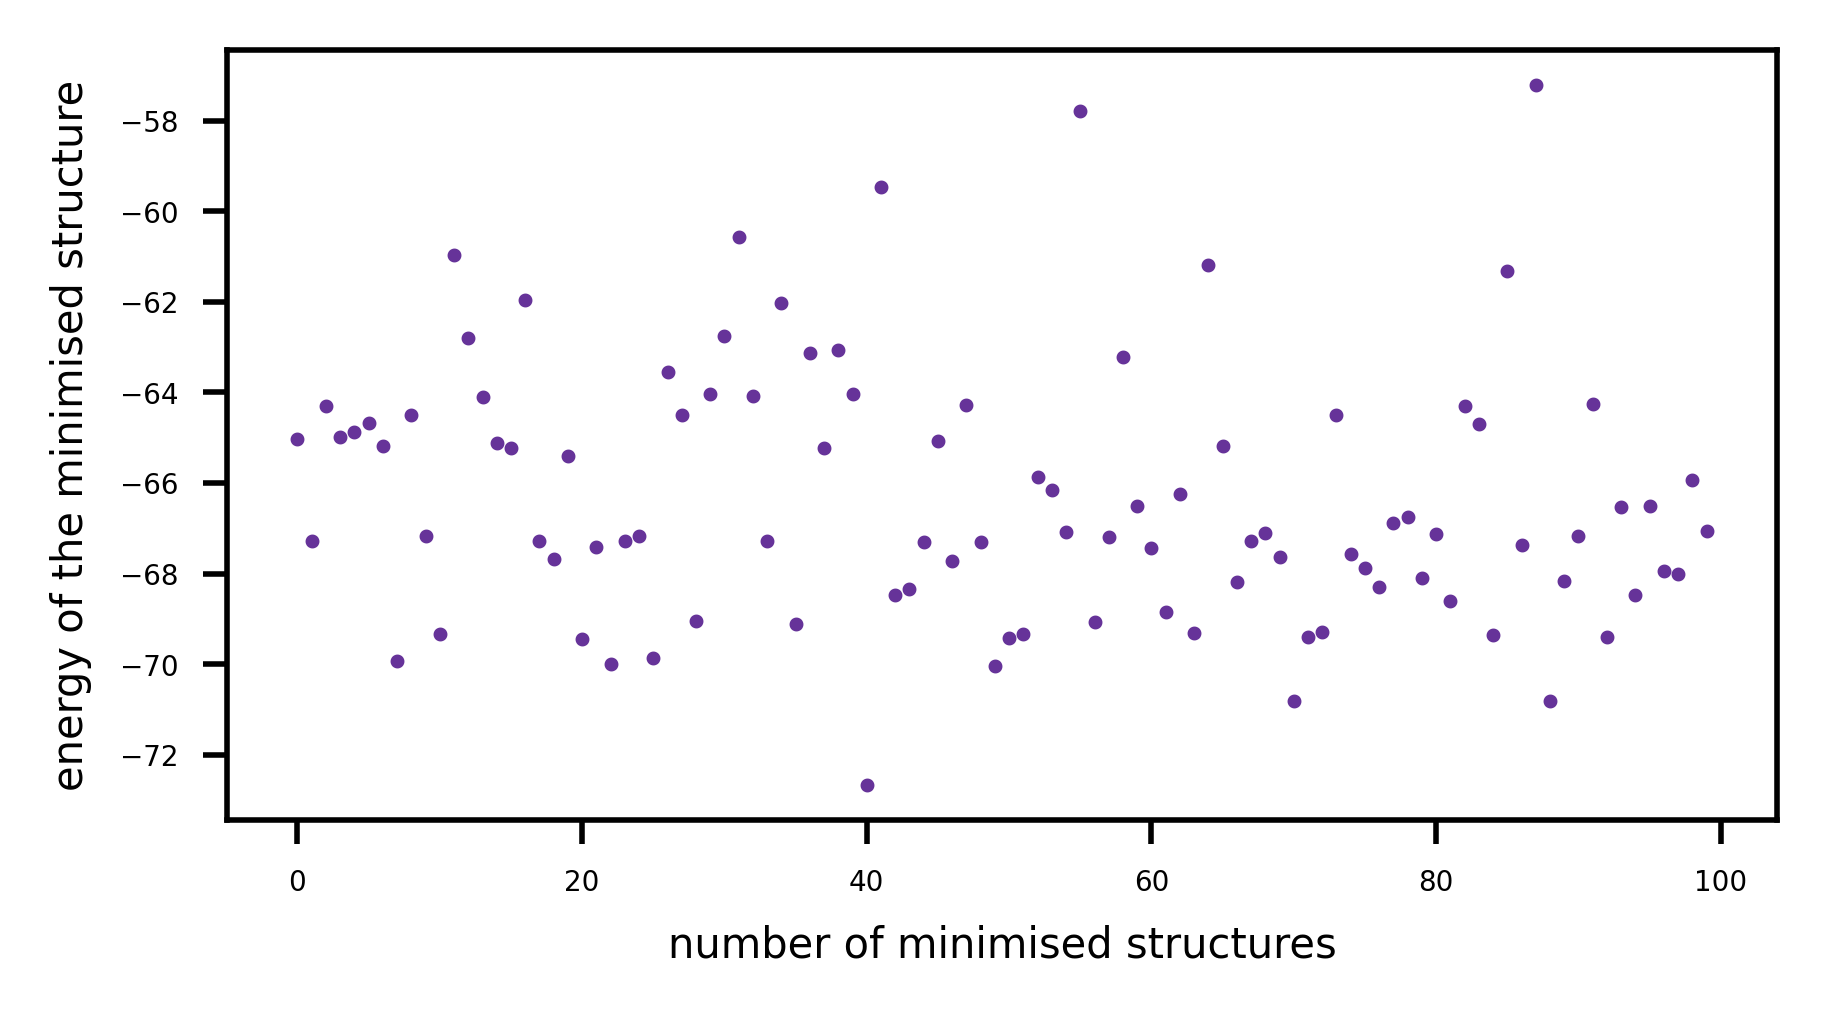

In [ ]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('LJ19_min_test.png')

## Step 5

Implementation of the basin hopping algorithm

In [ ]:
def perturb_structure(atoms, method = 'wild', magnitude = 3.0, k = 3):
    '''
    Pertubation Methods
    '''
    def wild(atoms=atoms, magnitude=magnitude):
        '''
        'wild' - randomly selects one atom and moves it in a random direction by a random amount, limited
        by the `magnitude` variable
        '''
        atom_index = np.random.randint(len(atoms) - 1) #selects a random atom from the cluster

        rng = np.random.default_rng()
        direction = rng.normal(size = 3) #randomising the direction the selected atom will be moved
        direction /= np.linalg.norm(direction, keepdims = True) #normalising to produce a unit vector
        length = np.random.uniform(low = 0.0, high = magnitude) #random magnitude between 0 and the specified magnitude
        atoms.positions[atom_index] += direction * length
        
        return atoms
    
    def stretch(atoms=atoms, magnitude = magnitude):
        '''
        'stretch' - calculates the centroid of the cluster, then moves all the atoms away from that centroid
        before performing the energy minimisation. Additional parameter can control how far away all of the
        atoms are moved.
        '''
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        norms = np.linalg.norm(vectors, axis = 1)
        mask = norms > 0.0
        unit_vectors = vectors[mask]/norms[mask, None]

        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (unit_vectors.shape[0], 1))
        atoms.positions += unit_vectors * lengths
        return atoms

    def sweep(atoms=atoms, magnitude=magnitude, k=3):
        '''
        'sweep' - computes cluster centroid, moves the k-furthest atoms in a random directions by a random amount.
        Based on the idea that the core of the cluster is likely stable, but the outermost atoms are those that
        need to be displaced.
        '''

        # Computing distance from centre of the cluster
        centroid = np.mean(atoms.positions, axis = 0)
        vectors = atoms.positions - centroid
        distances = np.linalg.norm(vectors, axis = 1)
        
        #identifying the k-furthest atoms from the centre of the cluster
        idx = np.argsort(distances)[-k:][::-1]

        rng = np.random.default_rng()
        directions = rng.normal(size = (len(idx), 3)) #randomising the directions each of the k-furthest atoms will be moved
        directions /= np.linalg.norm(directions, axis=1, keepdims = True) #normalising to produce the unit vector
        lengths = np.random.uniform(low = 0.0, high = magnitude, size = (directions.shape[0], 1)) #random magnitudes
        
        atoms.positions[idx] += directions * lengths
        return atoms
    
    def swap(atoms):
        '''
        'swap' - swap two random atoms coordinates. e.g. randomly swap the x coordinate of atom a with the x
        coordinate of atom b. OR randomly swap the y coordinate of atom a with the z coordinate of atom b
        '''
        rng = np.random.default_rng()
        n = len(atoms)
        #randomising the atoms selected to be swapped
        atom_a = rng.integers(0, n)
        atom_b = rng.integers(0, n)

        #randomising the x, y, z coordinate to be swapped
        comp_a = rng.integers(0, 3)
        comp_b = rng.integers(0, 3)

        atoms.positions[atom_a, comp_a], atoms.positions[atom_b, comp_b] = atoms.positions[atom_b, comp_b], atoms.positions[atom_a, comp_a]

        return atoms

    if method == 'wild':
        return wild(atoms, magnitude)
        
    elif method == 'stretch':
        return stretch(atoms, magnitude)

    elif method == 'sweep':
        return sweep(atoms, magnitude, k)
    
    elif method == 'swap':
        return swap(atoms)
    


In [ ]:
n = 19 # number of LJ atoms
box_length = 12 # length of box side

energies = []
structures = []
minima = []

global_min = float('inf')

for i in range(100):
    if i == 0:
        lj_19 = initialise_structure(n = n, box_length = box_length)
    else:
        lj_19 = perturb_structure(minimum.copy(), method = 'swap')

    minimise_structure(lj_19, id = i)

    energy = lj_19.get_potential_energy()
    energies.append(energy)
    structures.append(lj_19)

    # minimum variable stores the structure with the lowest energy
    if energy < global_min:
        minimum = lj_19.copy()
        minimum.calc = lj_calc
        global_min = energy
        minima.append(minimum)
    

      Step     Time          Energy          fmax
BFGS:    0 18:08:59    47361.827891  1248272.309175
BFGS:    1 18:08:59       49.709775      592.506531
BFGS:    2 18:08:59        5.345858      198.896982
BFGS:    3 18:08:59       -6.210202       28.571050
BFGS:    4 18:08:59       -8.063991        9.319486
BFGS:    5 18:08:59       -8.959525        3.742606
BFGS:    6 18:08:59       -9.446258        9.584078
BFGS:    7 18:08:59      -10.514343        3.370748
BFGS:    8 18:08:59        5.723405      209.413369
BFGS:    9 18:08:59      -11.238564        3.113710
BFGS:   10 18:08:59      -11.646638        5.685583
BFGS:   11 18:08:59       -8.818176       49.126850
BFGS:   12 18:08:59      -12.223758        3.434197
BFGS:   13 18:08:59      -12.782200        3.523600
BFGS:   14 18:08:59       -4.493931      163.215028
BFGS:   15 18:08:59      -13.455196        3.930065
BFGS:   16 18:08:59      -13.872192        3.638683
BFGS:   17 18:08:59       -8.352189      118.179096
BFGS:   18 18:

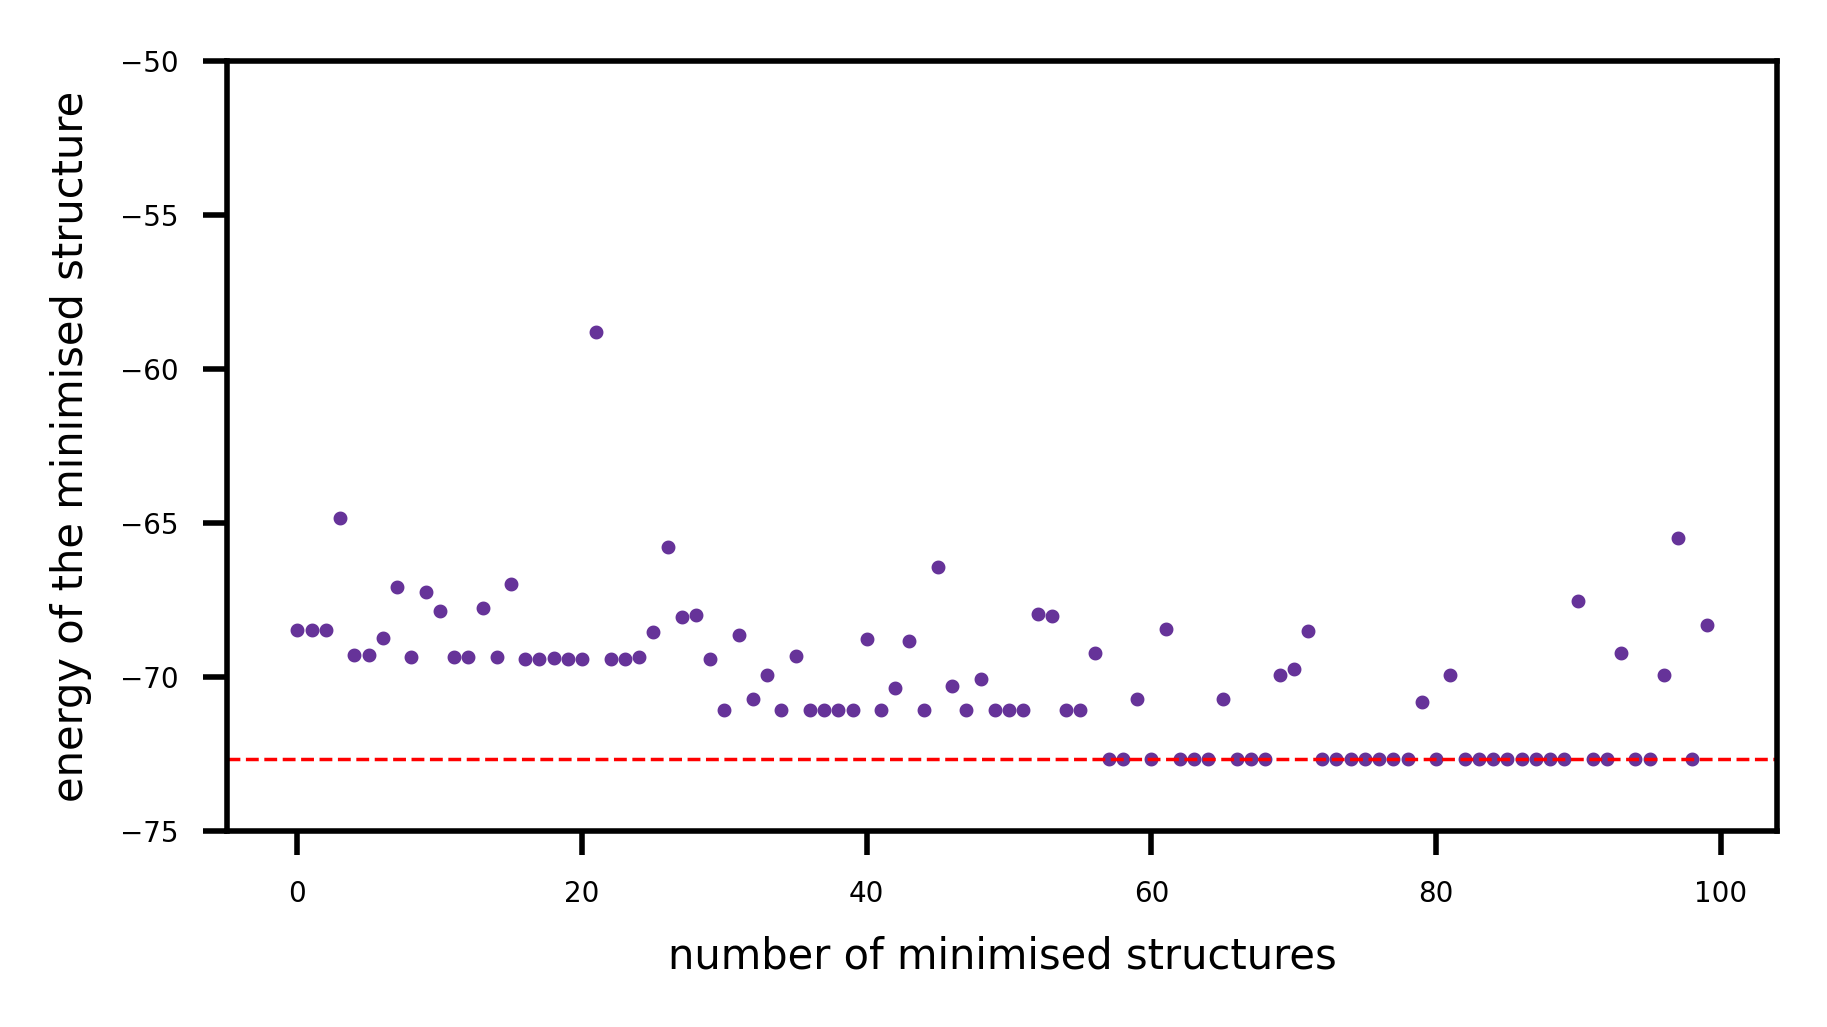

In [ ]:
fig=plt.figure(num=None,figsize=(4,2),dpi=500,facecolor='w',edgecolor='k')
plt.tick_params(axis='both', which='major', labelsize=4)
plt.xlabel('number of minimised structures',fontsize=6)
plt.ylabel('energy of the minimised structure',fontsize=6)
plt.ylim(-75, -50)
plt.axhline(y = -72.659782, color = 'r', linestyle = '--', lw=0.5)
plt.scatter(np.arange(len(energies)),energies,color='rebeccapurple',s=1)
plt.savefig('./images/LJ19_min_demo.png')

## Analysis of Pertubation Methods

Varied Magnitude of pertubation up from 1.0 up to 12.0 (to be ridiculous)[1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 12.0]

#### 'Wild'
- pertubation magnitude


#### 'Stretch'
- pertubation magnitude

#### 'Sweep'

Investigate two variables:
- number of atoms to 'sweep' -- from 1 up to 8
- magnitude of pertubation -- from 1.0 up to 12.0 (to be ridiculous)

As magnitude of pertubation increases ...

As the number of atoms perturbed, k, increases, ...

#### 'Swap'

...


### Conclusions
The best performing pertubation method was '', with magnitude = ... (and k = ...) . Generally it was seen that as magnitude of pertubtation was increased, ... . For 'Sweep', where the user could select the number of atoms to perturb, it was seen that was the number of atoms to perturb increased ... .

However it is important to take the conclusions from these results with a pinch of salt, as the 'performance' (being measured as the method that finds the global minimum in the fewest number of iterations) is heavily influenced by the very first minimised structure. e.g. if the first structure minimises to -70 kj mol, in this system it seems that it is much more likely to find the global minimum in fewer iterations, compared to an equivalent method but the first configuration minimises to -60 kj mol-1 instead. A proper investigation should 'sample' the performance by running multiple (e.g. 20) iterations of starting from a new random structure.
